Imagina que você vende produtos para pets aí na sua região e deseja começar vender online nos principais marketplaces (Mercado Livre, Americanas, Amazon, Magazine Luiza…). Publicar seus produtos em cada um desses markeplaces pode ser bem trabalhoso e talvez até inviável financeiramente, então aí que entra o Olist. O Olist basicamente é um intermediador entre sellers (você) e os marketplaces. Os sellers gerenciam seus produtos por meio da plataforma digital do Olist, e o Olist cuida de publicar os produtos nos marketplaces, realizar as vendas e fazer o repasse $$ para os sellers.

A ideia aqui é: você está no papel de um cientista de dados que trabalha no Olist. De um lado você tem os sellers e do outro os marketplaces. Do ponto de vista dos sellers, cliente é quem compra o produto vendido. Do ponto de vista do Olist, os sellers são os clientes, pois são eles que contratam o Olist. O Olist quer aumentar a retenção de clientes (sellers) e deseja usar inteligência de dados para isso. Numa discussão entre o time de dados e a área de negócio, enxergou-se a necessidade de termos um modelo preditivo para antever os sellers propensos a abandonar o relacionamento com o Olist (sellers propensos a churn), e você foi escalado para puxar esta iniciativa.

Extraia os dados disponibilizados no GitHub e siga o CRISP-DM (https://medium.com/@ia.bb/crisp-dm-organizando-seu-projeto-de-mineração-de-dados-fdb0399cbd9b) para desenvolver este modelo.
Aí vá trabalhando nisso e quando quiser puxar a agenda (ou agendas) comigo, só avisar.

Importing the libraries

In [1]:
#requirements

# !pip install pandas numpy scikit-learn matplotlib seaborn plotly.express nbformat

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
#For pattern pandas hides some columns when the DF has many. This code disables this:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Loading the data sets
orders = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_orders_dataset.csv')
customers = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_customers_dataset.csv')
reviews = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_order_reviews_dataset.csv')
payments = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_order_payments_dataset.csv')
order_items = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_order_items_dataset.csv')
products = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_products_dataset.csv')
sellers = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_sellers_dataset.csv')
geo_location = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\olist_geolocation_dataset.csv')
prod_category = pd.read_csv(r'C:\Users\JOÃO PAULO FERNANDES\Documents\PROJECTS\Olist\work-at-olist-data-master\datasets\product_category_name_translation.csv')


In [5]:
# Lets create a unique data frame by merging all of them
df = orders.merge(customers, on='customer_id', how='outer')
df = df.merge(reviews, on='order_id', how='outer')
df = df.merge(payments, on='order_id', how='outer')
df = df.merge(order_items, on='order_id', how='outer')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')
geo_location.rename(columns= {'geolocation_zip_code_prefix':'customer_zip_code_prefix'}, inplace = True)
df = df.merge(geo_location, on='customer_zip_code_prefix', how='outer')

In [6]:
# Taking a sample to make the testing faster
df = df.sample(n=100000, replace=True)

Data Cleaning

In [7]:
df.isna().sum()

order_id                           167
customer_id                        167
order_status                       167
order_purchase_timestamp           167
order_approved_at                  311
order_delivered_carrier_date      1976
order_delivered_customer_date     2981
order_estimated_delivery_date      167
customer_unique_id                 167
customer_zip_code_prefix             0
customer_city                      167
customer_state                     167
review_id                          923
review_score                       923
review_comment_title             88782
review_comment_message           58954
review_creation_date               923
review_answer_timestamp            923
payment_sequential                 174
payment_type                       174
payment_installments               174
payment_value                      174
order_item_id                      857
product_id                         857
seller_id                          857
shipping_limit_date      

Observations:

It's normal to have some columns with null values, like 'review_comment_title' and 'review_comment_message'.
But it isn't for others like 'order_id' and 'customer_id'. So let's do a cleaning on it:

In [8]:
# Drop rows with null values considering specific columns
df.dropna(subset=['customer_id','seller_id'], inplace=True)
print(df.isnull().sum())

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   20
order_delivered_carrier_date      1119
order_delivered_customer_date     2124
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
review_id                          747
review_score                       747
review_comment_title             88010
review_comment_message           58556
review_creation_date               747
review_answer_timestamp            747
payment_sequential                   7
payment_type                         7
payment_installments                 7
payment_value                        7
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date      

In [9]:
# Searching for duplicated values
df.duplicated().sum()

1017

In [10]:
#Dropping the identical rows
df = df.drop_duplicates()

#### Exploratory data Analysis and visualization

In [11]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state'],

In [12]:
#Lets take a look at the reviews distribution
fig = px.histogram(df, x="review_score", width=600, height=350, text_auto=True)
fig.update_yaxes(tickformat=',.3s', title='Review count in Thousands')
fig.show()

In [13]:
df['order_purchase_timestamp'].dtype

dtype('O')

In [14]:
df['order_purchase_timestamp'].head(2)

9728242     2018-08-19 18:34:21
11532719    2017-11-05 14:24:46
Name: order_purchase_timestamp, dtype: object

In [15]:
# Converting the columns to the format we'll use when building the graph
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

Text(0, 0.5, 'Count')

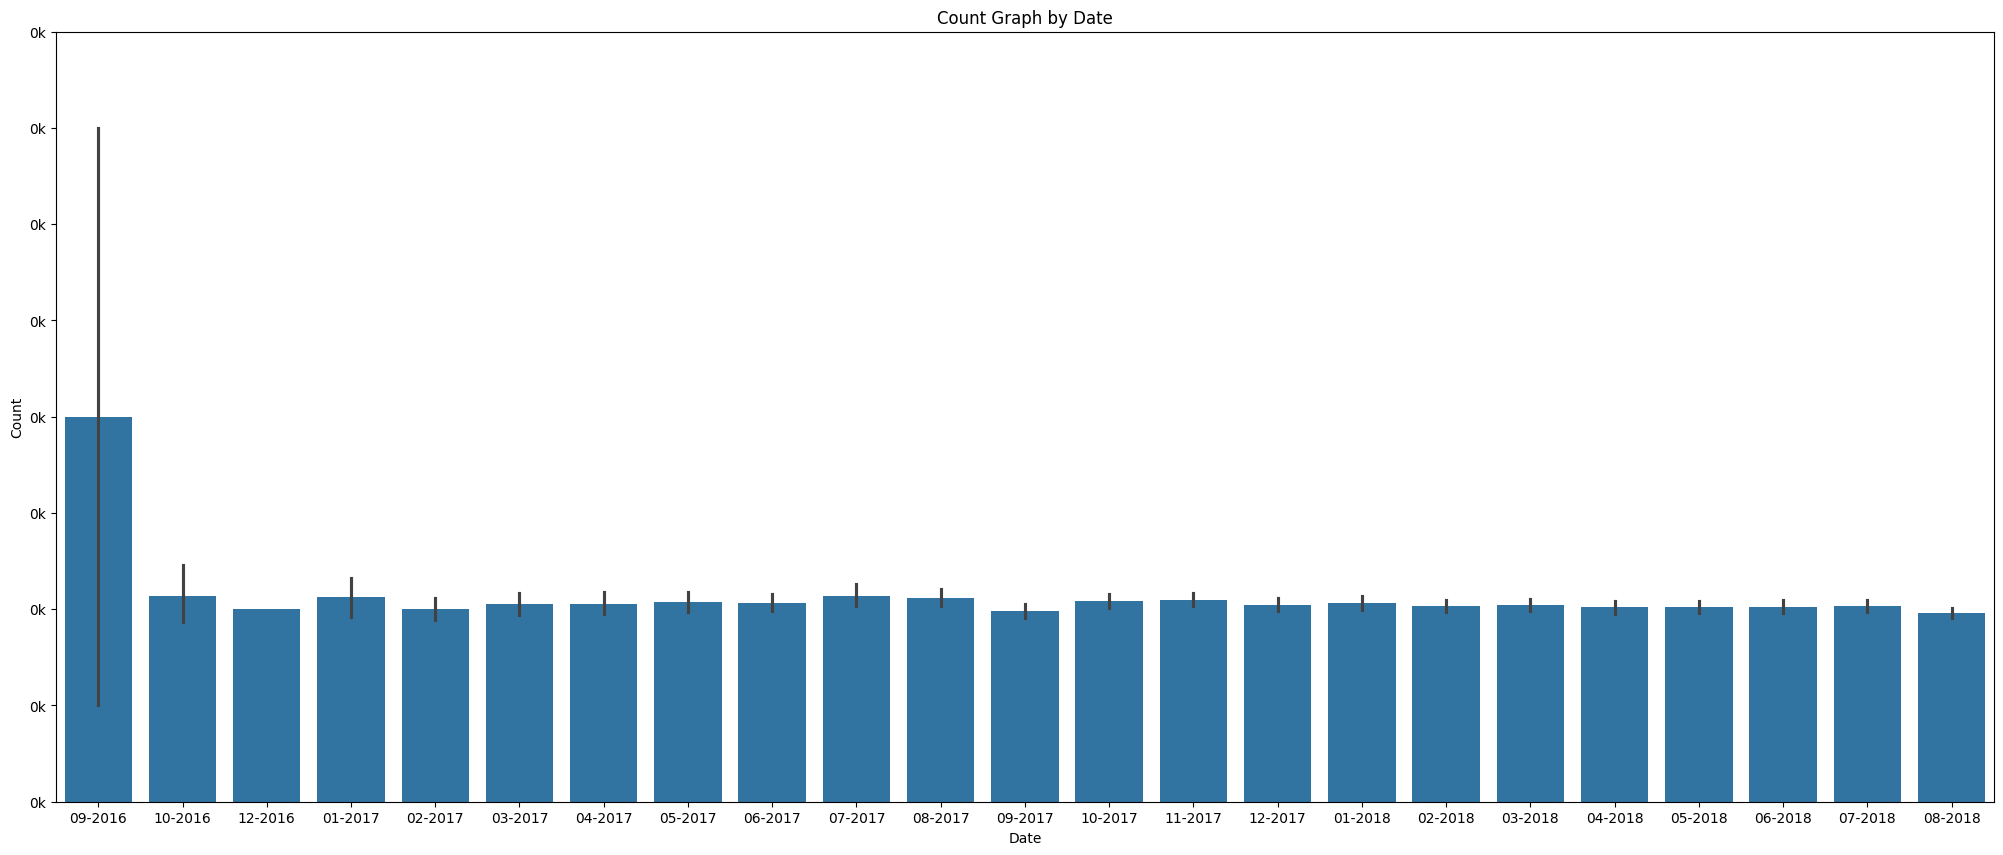

In [16]:
date_counts = df.groupby('order_purchase_timestamp')['order_id'].count().reset_index().sort_values(by='order_purchase_timestamp')

# Plot the count graph
plt.figure(figsize=(25, 10))
sns.barplot(x=date_counts['order_purchase_timestamp'].dt.strftime('%m-%Y'), y='order_id', data=date_counts)

# Customize the plot
plt.ylabel('Count (in thousands)')
plt.yticks(plt.yticks()[0], [f'{int(val/1000)}k' for val in plt.yticks()[0]])
plt.title('Count Graph by Date')
plt.xlabel('Date')
plt.ylabel('Count')

In [17]:
# Now lets create a graph to see the distribution by seller and by ratting
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state'],

In [18]:
df['seller_id'].nunique()

2642

There is correlation between the time to deliver and the ratting?

In [19]:
df['order_estimated_delivery_date'].head(3)

9728242     2018-09-12 00:00:00
11532719    2017-12-06 00:00:00
13433358    2017-12-01 00:00:00
Name: order_estimated_delivery_date, dtype: object

In [20]:
df['order_delivered_customer_date'].head(2)

9728242     2018-08-28 19:36:39
11532719    2017-11-10 17:48:47
Name: order_delivered_customer_date, dtype: object

In [21]:
df['delivery_delay'] = (pd.to_datetime(df['order_delivered_customer_date']) - pd.to_datetime(df['order_estimated_delivery_date'])).dt.days.fillna(0).astype(int)

In [22]:
px.scatter(df, title="Ratting according delivery delay",
           x='delivery_delay',
           y= 'review_score')

In [23]:
correlation_coefficient = df['delivery_delay'].corr(df['review_score'])
print(f'Correlation Coefficient: {correlation_coefficient}')

Correlation Coefficient: -0.2561188140404876


So we saw that the delivery delay it's not the crucial variable to low ratting.

Next step is to seeing the sellers wich clientes stop buying:

In [24]:
# First of all lets convert the order purchase date do datetime:

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [25]:
# Lets evaluate which is the range of dates in our data frame
last_date = df['order_purchase_timestamp'].max()
first_date = df['order_purchase_timestamp'].min()

date_range = last_date - first_date; date_range

Timedelta('723 days 17:36:41')

In [26]:
''' Now we know the range of dates of our dataframe is 723 days, 
 lets consideer inactive (churn) a client that doesn't buy anything in 90 days '''

#Converting the column to datetime type
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

#Creating the new column with binary values. 1 if a churn happened, 0 if doesn't.
df['churn'] = df['order_purchase_timestamp'].apply(lambda row: 1 if (last_date - row).days > 180 else 0)

Ok, once we already have prepared our data frame, lets start building our model. But first, lets split the DF in three parts:

1. **Training set** - to train the model, compute the loss and adjust the model weights using an optimization technique
2. **Validaton set** - to evaluate the model during training, to fit model hyperparameters (optimization, regularization, etc) and pick the best version of the model. The validation set is essential for training models that generalize well.
3. **Test set** - Used to compare different models and their final accuracy. This part should reflect the kind of data the model will find in the real world.

We'll use 60% for the training set, 20% for the validation one and 20% for the test set

In [27]:
# importing the necessary library
from sklearn.model_selection import train_test_split

In [28]:
#Lets use just the numeric columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)

In [29]:
# Spliting the data frame
'''Step 1 - lets split the DF into two parts: the test_df and the train_val_df 
   (this second will be splitted in two later: train_df and val_df)'''

train_val_df, test_df = train_test_split(newdf, test_size=0.2, random_state=19)

'''Step 2 - Spliting the train_val_df into two. Consider that we want the proportional amout of 20% of the original dataframe
   Calling the test_df.shape we can that it have aproximately 10 thousand hows. And the train_val_df have 40 thousand hows.
   So here we'll need to use the test_size paramete equals to 0.25 to achieve the same number of rows to the validation df'''

train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=15)


In [30]:
print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (58875, 20)
val_df.shape:  (19625, 20)
test_df.shape:  (19626, 20)


Once we have time data, we need to be careful to the model doesn't use future data to predict the past, but just the oposite.
To make sure this will not happen, we'll need to split the data this way:

**Train and validation set**: The year before $\newline$
**Test set**: the last year.

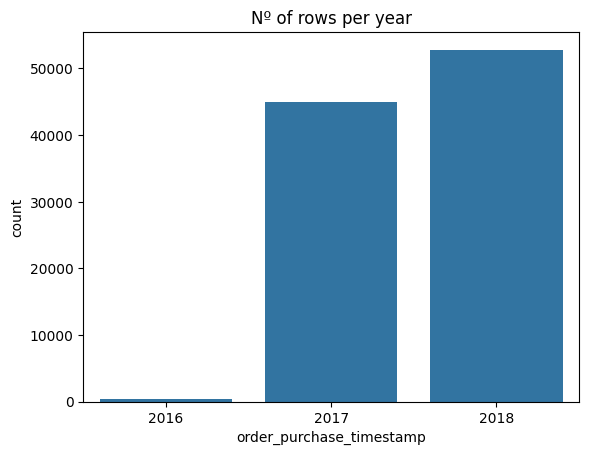

In [31]:
#Lets look the year distribution on our data frame
plt.title('Nº of rows per year')
sns.countplot(x=df['order_purchase_timestamp'].dt.year);

Here we can see that the data distribution its not favorable to keep you 60 - 20 - 20 % rate. $\newline$
So we'll just go ahead with the split we did before with the train_test_split function

#### Now lets identify the input and target columns

In [32]:
train_df.head()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay,churn
6012028,4459,4.0,1.0,1.0,36.77,1.0,28.99,7.78,63.0,937.0,2.0,200.0,16.0,4.0,16.0,9271.0,-23.693418,-46.671923,-7,1
15713493,21921,5.0,1.0,4.0,215.98,1.0,199.70,16.28,50.0,2830.0,2.0,350.0,27.0,4.0,11.0,1539.0,-22.803743,-43.188073,-21,0
14334066,8290,1.0,1.0,20.0,200.08,1.0,191.00,9.08,58.0,3784.0,7.0,225.0,25.0,18.0,18.0,11701.0,-23.556006,-46.447363,0,0
7647231,30570,1.0,1.0,3.0,158.97,5.0,29.95,7.84,51.0,1558.0,2.0,300.0,27.0,8.0,21.0,29100.0,-19.955974,-43.984052,-14,0
12145706,98005,4.0,1.0,1.0,45.00,1.0,29.90,15.10,NaN,NaN,NaN,200.0,16.0,2.0,11.0,13483.0,-28.645131,-53.606255,-6,1


In [33]:
input_cols = list(train_df.columns)[0:-1]
target_col = 'churn'


##### Now lets split the inputs and targets for the training, validation and test sets for further processing and model training

In [34]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [35]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [36]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [37]:
train_inputs.head(5)

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
6012028,4459,4.0,1.0,1.0,36.77,1.0,28.99,7.78,63.0,937.0,2.0,200.0,16.0,4.0,16.0,9271.0,-23.693418,-46.671923,-7
15713493,21921,5.0,1.0,4.0,215.98,1.0,199.70,16.28,50.0,2830.0,2.0,350.0,27.0,4.0,11.0,1539.0,-22.803743,-43.188073,-21
14334066,8290,1.0,1.0,20.0,200.08,1.0,191.00,9.08,58.0,3784.0,7.0,225.0,25.0,18.0,18.0,11701.0,-23.556006,-46.447363,0
7647231,30570,1.0,1.0,3.0,158.97,5.0,29.95,7.84,51.0,1558.0,2.0,300.0,27.0,8.0,21.0,29100.0,-19.955974,-43.984052,-14
12145706,98005,4.0,1.0,1.0,45.00,1.0,29.90,15.10,NaN,NaN,NaN,200.0,16.0,2.0,11.0,13483.0,-28.645131,-53.606255,-6


In [38]:
# We  can also split the columns between numeric and categorical:
numeric_columns = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_columns = train_inputs.select_dtypes("object").columns.tolist()

In [39]:
train_inputs[numeric_columns].describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
count,58875.000000,58439.000000,58870.000000,58870.000000,58870.000000,58875.000000,58875.000000,58875.000000,58020.000000,58020.000000,58020.000000,58863.000000,58863.000000,58863.000000,58863.00000,58875.000000,58871.000000,58871.000000,58875.000000
mean,32742.482293,4.034344,1.089961,2.934296,173.256458,1.205979,120.559708,19.625815,48.679869,778.001241,2.186091,2143.072134,30.505326,16.744271,23.18047,25131.944645,-21.932395,-45.920723,-12.047168
std,26863.538917,1.400108,0.655743,2.776003,260.643757,0.712731,182.246005,14.890006,10.079491,648.325483,1.711755,3797.635198,16.357109,13.445067,11.72958,28032.128946,4.279932,3.572772,10.281348
min,1007.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.850000,0.000000,5.000000,8.000000,1.000000,0.000000,7.000000,2.000000,7.00000,1001.000000,-33.531440,-72.667329,-140.000000
25%,13160.000000,4.000000,1.000000,1.000000,61.750000,1.000000,39.900000,13.470000,42.000000,343.000000,1.000000,300.000000,18.000000,8.000000,15.00000,6871.000000,-23.572974,-47.584076,-17.000000
50%,24020.000000,5.000000,1.000000,1.000000,110.000000,1.000000,74.990000,16.280000,51.000000,594.000000,1.000000,700.000000,25.000000,13.000000,20.00000,13920.000000,-22.907706,-46.450656,-13.000000
75%,38400.000000,5.000000,1.000000,4.000000,190.620000,1.000000,135.000000,20.420000,57.000000,970.000000,3.000000,1831.500000,39.000000,20.000000,30.00000,30270.000000,-20.406716,-43.347581,-7.000000
max,99980.000000,5.000000,29.000000,24.000000,13664.080000,19.000000,6729.000000,375.280000,72.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.00000,99730.000000,2.864275,-34.805330,188.000000


### Handling missing numeric Data

#### Machine learning models can't work with missing numeric data. The process of filling missing values is called imputation.
There are a lot of techniques for imputation, but we'll use the most basic one: Replace with the average value in the column.
We'll do it using the SimpleImputer class from sklearn.impute.

In [40]:
from sklearn.impute import SimpleImputer

In [41]:
imputer = SimpleImputer(strategy= 'mean')

In [42]:
# Lets check the number of null/missing values before applying the imputer:
df[numeric_columns].isna().sum()

customer_zip_code_prefix         0
review_score                   743
payment_sequential               7
payment_installments             7
payment_value                    7
order_item_id                    0
price                            0
freight_value                    0
product_name_lenght           1442
product_description_lenght    1442
product_photos_qty            1442
product_weight_g                18
product_length_cm               18
product_height_cm               18
product_width_cm                18
seller_zip_code_prefix           0
geolocation_lat                  4
geolocation_lng                  4
delivery_delay                   0
dtype: int64

In [43]:
# Firt we'll fit the imputer to the data:
imputer.fit(df[numeric_columns])

SimpleImputer()

In [44]:
# After run the previously code, the statistic for each column is stored in the statistics_ property of imputer
list(imputer.statistics_)

[32780.46540162648,
 4.02932750069314,
 1.0921737889705359,
 2.9268133592882113,
 173.4208053486073,
 1.206428469518782,
 121.10687432484765,
 19.62008366793714,
 48.66340863017666,
 780.5412891481527,
 2.1945099499400107,
 2147.4796041097566,
 30.525512700289475,
 16.710196925836833,
 23.151058017694787,
 25129.45574057844,
 -21.94948650173076,
 -45.93856229895075,
 -12.040142266066079]

In [45]:
# Now we can fill the missing values on the training, test and validation sets using the transform method of imputer
train_inputs[numeric_columns] = imputer.transform(train_inputs[numeric_columns])
val_inputs[numeric_columns] = imputer.transform(val_inputs[numeric_columns])
test_inputs[numeric_columns] = imputer.transform(test_inputs[numeric_columns])

In [46]:
# Checking the results
train_inputs[numeric_columns].isna().sum()

customer_zip_code_prefix      0
review_score                  0
payment_sequential            0
payment_installments          0
payment_value                 0
order_item_id                 0
price                         0
freight_value                 0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
seller_zip_code_prefix        0
geolocation_lat               0
geolocation_lng               0
delivery_delay                0
dtype: int64

### Scaling numeric features

Optimization algorithms work better with smallers numbers. So a good practice when working with machine learning is to scale numeric values into small ranges like (0, 1) or (-1, 1).

In [47]:
# Our data have a different range os values:
df[numeric_columns].describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
count,98126.000000,97383.000000,98119.000000,98119.000000,98119.000000,98126.000000,98126.000000,98126.000000,96684.000000,96684.000000,96684.00000,98108.000000,98108.000000,98108.000000,98108.000000,98126.000000,98122.000000,98122.000000,98126.000000
mean,32780.465402,4.029328,1.092174,2.926813,173.420805,1.206428,121.106874,19.620084,48.663409,780.541289,2.19451,2147.479604,30.525513,16.710197,23.151058,25129.455741,-21.949487,-45.938562,-12.040142
std,26958.052478,1.401377,0.679270,2.778603,259.004998,0.711490,185.016337,14.864827,10.106973,649.662884,1.71883,3802.939322,16.373918,13.370725,11.722015,28039.212800,4.294116,3.561823,10.281954
min,1007.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.00000,0.000000,7.000000,2.000000,7.000000,1001.000000,-33.690223,-72.670987,-147.000000
25%,13146.500000,4.000000,1.000000,1.000000,61.750000,1.000000,39.920000,13.470000,42.000000,342.000000,1.00000,300.000000,18.000000,8.000000,15.000000,6853.000000,-23.573735,-47.618231,-17.000000
50%,23970.000000,5.000000,1.000000,1.000000,110.240000,1.000000,75.000000,16.280000,51.000000,596.000000,1.00000,700.000000,25.000000,13.000000,20.000000,13920.000000,-22.908999,-46.454542,-13.000000
75%,38400.000000,5.000000,1.000000,4.000000,191.460000,1.000000,136.375000,20.400000,57.000000,975.000000,3.00000,1836.000000,39.000000,20.000000,30.000000,30303.750000,-20.425053,-43.351112,-7.000000
max,99980.000000,5.000000,29.000000,24.000000,13664.080000,21.000000,6735.000000,375.280000,72.000000,3992.000000,20.00000,40425.000000,105.000000,105.000000,118.000000,99730.000000,2.864275,-34.805330,188.000000


In [48]:
# To turn the value into the same magnitude, we'll use the MinMaxScaler from sklearn.preprocessing:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scaler = MinMaxScaler()

In [50]:
# First we fit the scaler to the data:
scaler.fit(df[numeric_columns])

MinMaxScaler()

In [51]:
#Lets cheack the min and max values in each column:
print('Min: ')
list(scaler.data_min_)

Min: 


[1007.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.85,
 0.0,
 5.0,
 4.0,
 1.0,
 0.0,
 7.0,
 2.0,
 7.0,
 1001.0,
 -33.69022260512682,
 -72.67098698091266,
 -147.0]

In [52]:
print('Max: ')
list(scaler.data_max_)

Max: 


[99980.0,
 5.0,
 29.0,
 24.0,
 13664.08,
 21.0,
 6735.0,
 375.28,
 72.0,
 3992.0,
 20.0,
 40425.0,
 105.0,
 105.0,
 118.0,
 99730.0,
 2.864274875621507,
 -34.80533030408559,
 188.0]

In [53]:
# So lets scale our training, validations and test DF:
train_inputs[numeric_columns] = scaler.transform(train_inputs[numeric_columns])
val_inputs[numeric_columns] = scaler.transform(val_inputs[numeric_columns])
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

In [54]:
# Lets verify how it behaved
train_inputs[numeric_columns].describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
count,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000,58875.000000
mean,0.320648,0.758577,0.003213,0.122262,0.012680,0.010299,0.017777,0.052296,0.651935,0.194092,0.062432,0.053014,0.239850,0.143148,0.145770,0.244416,0.321652,0.706452,0.402844
std,0.271423,0.348728,0.023418,0.115662,0.019074,0.035637,0.027063,0.039677,0.149344,0.161384,0.089436,0.093933,0.166892,0.130521,0.105661,0.283930,0.117080,0.094351,0.030691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004344,0.000097,0.020896
25%,0.122791,0.750000,0.000000,0.041667,0.004519,0.000000,0.005799,0.035893,0.552239,0.086008,0.000000,0.007421,0.112245,0.058252,0.072072,0.059456,0.276773,0.662531,0.388060
50%,0.232518,1.000000,0.000000,0.041667,0.008050,0.000000,0.011010,0.043381,0.686567,0.149699,0.000000,0.017316,0.183673,0.106796,0.117117,0.130853,0.294972,0.692457,0.400000
75%,0.377810,1.000000,0.000000,0.166667,0.013950,0.000000,0.019921,0.054413,0.776119,0.239468,0.105263,0.045343,0.326531,0.174757,0.207207,0.296458,0.363383,0.774406,0.417910
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.900000,0.999109,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Encoding categorical Data

 As we said before, machine learning can only be trained with numeric data, so we need to convert categorical data to numbers like this:

<table>
<tr><th> Reference </th><th> Encoded Data </th></tr>
<tr><td>

| Index |  Category  |
| --- |  ---  |
|  1  | Cat A  |
|  2  | Cat B  |
|  3  | Cat C  |

</td><td>

|Index|Cat A|Cat B|Cat C| 
|--|--|--|--|
|1|1|0|0|
|2|0|1|0|
|3|0|0|1|

</td></tr> </table>

As we can see, encoding is about to apply binary values for each column in a given row to tell us if the value belongs to a category.

In [59]:
# To do what we talked about above we'll use the OneHotEncoder
df[categorical_columns].nunique()

Series([], dtype: float64)